In [59]:
import pandas as pd
import seaborn as sns
import numpy as np
import time
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
import matplotlib.pyplot as plt # plotting
from pandas import DataFrame
from math import sqrt
from sklearn.metrics import mean_squared_error




In [60]:
WAVE_PATH = "/content/wave.csv"
datas = pd.read_csv(WAVE_PATH,parse_dates=True,index_col=0,nrows=25000) 
datas.replace(-99.90, np.nan, inplace=True)
datas = datas.interpolate(limit_direction='both')
datas.index = pd.to_datetime(datas.index).to_period('15T')
datas = datas.rename(columns={'Peak Direction': 'Peak_Direction'})
datas = datas.rename(columns={'SST': 'Temperature'})
datas = datas.rename(columns={'Tz': 'Period'})

In [61]:
datas.describe()

,Hs,Hmax,Period,Tp,Peak_Direction,Temperature
count,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000,25000.000000
mean,1.251213,2.114953,5.604457,8.989630,99.436840,24.383406
std,0.532747,0.906852,0.968950,2.490403,25.258617,2.087168
min,0.294000,0.530000,3.076000,2.720000,11.000000,20.500000
25%,0.840000,1.420000,4.933000,7.237000,87.000000,22.600000
50%,1.137000,1.920000,5.502000,8.834000,102.000000,24.250000
75%,1.560000,2.630000,6.150250,10.743000,118.000000,26.350000
max,3.520000,7.030000,10.921000,17.424000,257.000000,28.650000


In [62]:
print(datas.head())
print(datas.shape)
print(datas.columns)


                     Hs  Hmax  Period     Tp  Peak_Direction  Temperature
Date/Time                                                                
2017-01-01 00:00  0.875  1.39   4.421  4.506            49.0        25.65
2017-01-01 00:30  0.875  1.39   4.421  4.506            49.0        25.65
2017-01-01 01:00  0.763  1.15   4.520  5.513            49.0        25.65
2017-01-01 01:30  0.770  1.41   4.582  5.647            75.0        25.50
2017-01-01 02:00  0.747  1.16   4.515  5.083            91.0        25.45
(25000, 6)
Index(['Hs', 'Hmax', 'Period', 'Tp', 'Peak_Direction', 'Temperature'], dtype='object')


In [63]:
datas

,Hs,Hmax,Period,Tp,Peak_Direction,Temperature
Date/Time,,,,,,
2017-01-01 00:00,0.875,1.390,4.421,4.506,49.0,25.65
2017-01-01 00:30,0.875,1.390,4.421,4.506,49.0,25.65
2017-01-01 01:00,0.763,1.150,4.520,5.513,49.0,25.65
2017-01-01 01:30,0.770,1.410,4.582,5.647,75.0,25.50
2017-01-01 02:00,0.747,1.160,4.515,5.083,91.0,25.45
...,...,...,...,...,...,...
2018-06-05 17:30,1.538,2.484,5.502,9.957,118.0,23.10
2018-06-05 18:00,1.527,2.663,5.356,10.852,120.0,23.10
2018-06-05 18:30,1.564,2.500,5.532,10.992,122.0,23.05


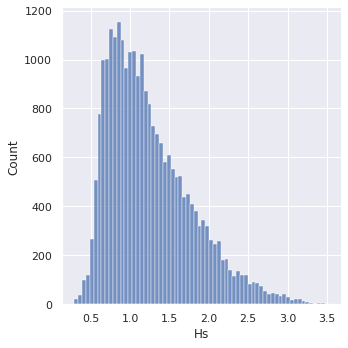

In [64]:
sns.displot(datas["Hs"])

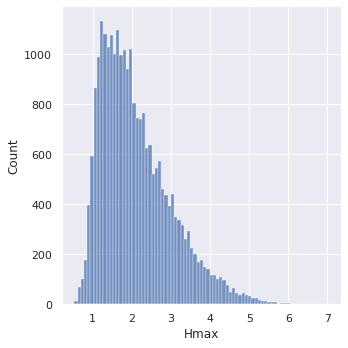

In [65]:
sns.displot(datas["Hmax"])

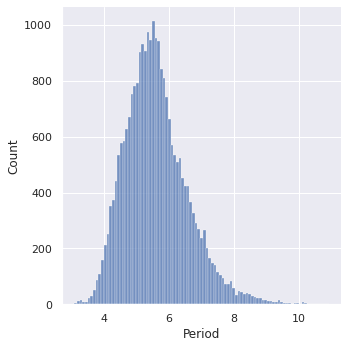

In [66]:
sns.displot(datas["Period"])

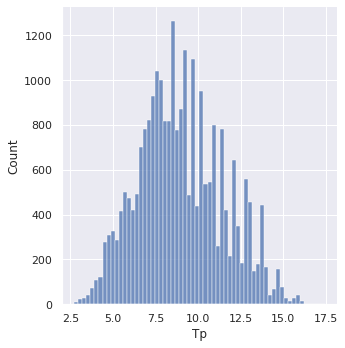

In [67]:
sns.displot(datas["Tp"])

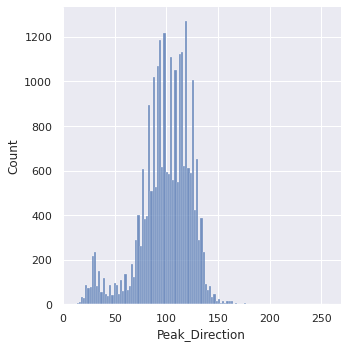

In [68]:
sns.displot(datas["Peak_Direction"])

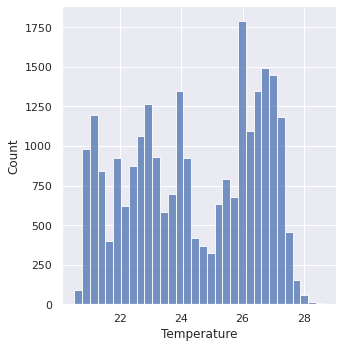

In [69]:
sns.displot(datas["Temperature"])

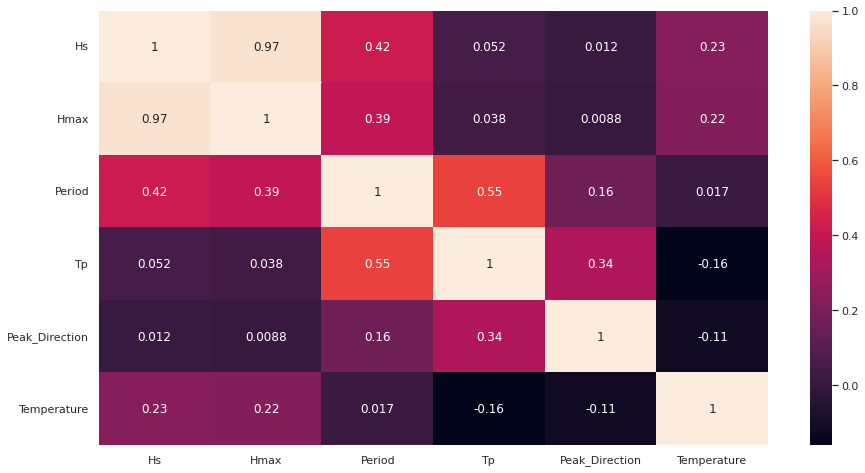

In [70]:
sns.heatmap(datas.corr(),annot=True)

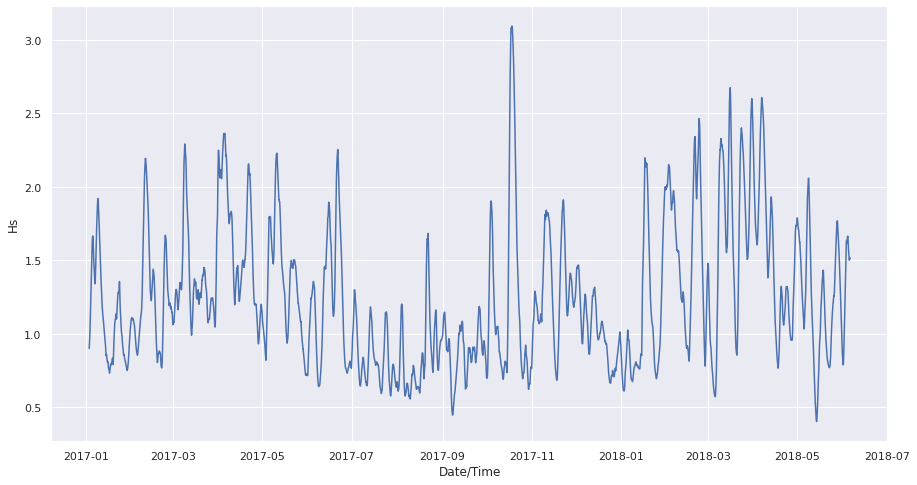

In [71]:
#remove noise
rolling =  datas.rolling(window=100).mean()
rolling.dropna(inplace=True)
sns.set(rc = {'figure.figsize':(15,8)})
sns.lineplot(data=rolling,x=rolling.index.to_timestamp(),y="Hs")

In [72]:
train=datas.iloc[:-5000,1]
test=datas.iloc[-5000:,1]
print(train.shape,test.shape)

(20000,) (5000,)


In [73]:
result=adfuller(train)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
result_diff = adfuller(train.diff().dropna())
print('ADF Statistic: %f' % result_diff[0])
print('p-value: %f' % result_diff[1])

ADF Statistic: -7.279043
p-value: 0.000000
ADF Statistic: -29.376815
p-value: 0.000000


In [74]:
model = ARIMA(train, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

                             ARIMA Model Results                              
Dep. Variable:                 D.Hmax   No. Observations:                19999
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -741.864
Method:                       css-mle   S.D. of innovations              0.251
Date:                Mon, 07 Feb 2022   AIC                           1497.729
Time:                        21:43:48   BIC                           1553.053
Sample:                    01-01-2017   HQIC                          1515.829
                         - 02-21-2018                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            0.0002      0.001      0.238      0.812      -0.001       0.002
ar.L1.D.Hmax    -0.6624      0.007    -93.784      0.000      -0.676      -0.649
ar.L2.D.Hmax    -0.4166      0.008    -49.43

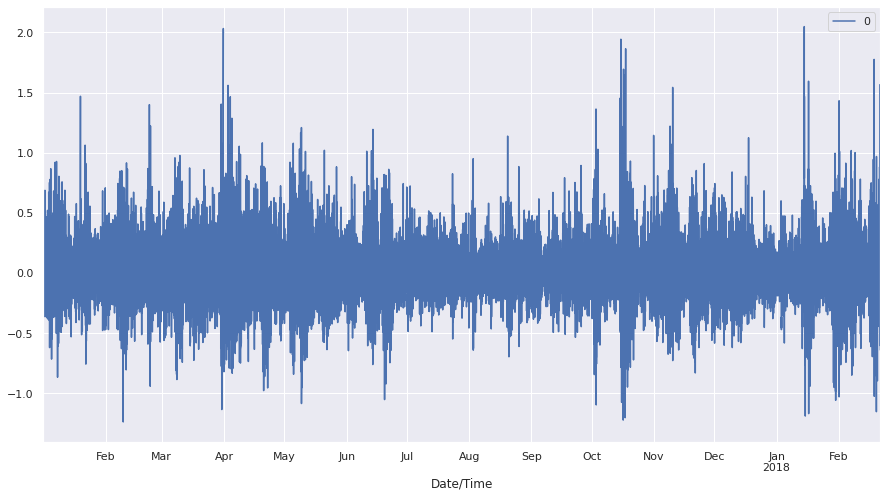

In [75]:
residuals = DataFrame(model_fit.resid)
residuals.plot()
plt.show()

In [76]:
# summary stats of residuals
print(residuals.describe())

                  0
count  19999.000000
mean      -0.000004
std        0.251119
min       -1.236446
25%       -0.142657
50%       -0.015980
75%        0.124893
max        2.047913


In [77]:
history = [x for x in train]
predictions = list()
# walk-forward validation
for t in range(len(test)):
	model = ARIMA(history, order=(5,1,0))
	model_fit = model.fit()
	output = model_fit.forecast()
	yhat = output[0]
	predictions.append(yhat)
	obs = test[t]
	history.append(obs)
	print('predicted=%f, expected=%f' % (yhat, obs))


predicted=4.748140, expected=5.120000
predicted=4.858983, expected=4.890000
predicted=4.869045, expected=4.491000
predicted=4.767191, expected=4.757000
predicted=4.761701, expected=4.810000
predicted=4.747241, expected=4.730000
predicted=4.760253, expected=4.145000
predicted=4.540326, expected=5.174000
predicted=4.734960, expected=4.253000
predicted=4.582380, expected=4.446000
predicted=4.534870, expected=3.790000
predicted=4.264649, expected=3.810000
predicted=4.088218, expected=3.870000
predicted=4.001263, expected=3.460000
predicted=3.775147, expected=4.317000
predicted=3.936320, expected=3.577000
predicted=3.800429, expected=4.432000
predicted=4.017673, expected=4.238000
predicted=4.100159, expected=3.790000
predicted=4.014749, expected=3.470000
predicted=3.844470, expected=5.270000
predicted=4.297082, expected=4.363000
predicted=4.357797, expected=4.230000
predicted=4.330099, expected=3.840000
predicted=4.160704, expected=4.180000
predicted=4.171843, expected=4.500000
predicted=4.

KeyboardInterrupt: ignored

Test RMSE: 0.308


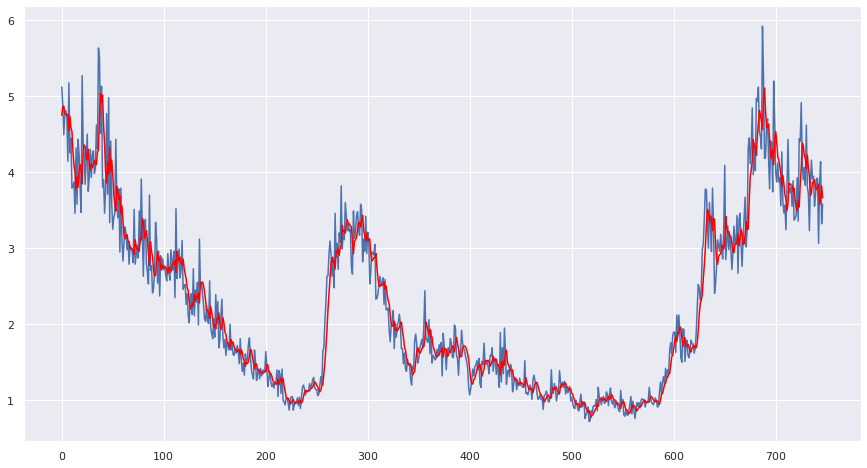

In [88]:
# evaluate forecasts
rmse = sqrt(mean_squared_error(test[:len(predictions)], predictions))
print('Test RMSE: %.3f' % rmse)
# plot forecasts against actual outcomes
plt.plot(test.values[:len(predictions)])
plt.plot(predictions, color='red')
plt.show()